In [4]:
import obspy
import os
import sys
from obspy.clients.fdsn import Client
LIBpath = os.path.join( os.getenv('HOME'),'Documents','GitHub','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import inventory2traceid, get_FDSN_inventory 
import RSAM


def FDSNdownload(stationXmlFile, mseedfile, fdsnURL, startt, endt, olat, olon, \
        searchRadiusDeg, network='*', station='*', chanstring='BHZ'):
    
    if os.path.isfile(stationXmlFile):
        inv = obspy.read_inventory(stationXmlFile)

    else:
        fdsnClient = Client(fdsnURL)
        inv = get_FDSN_inventory(fdsnClient, startt, stationXmlFile, network, olat, olon, \
            searchRadiusDeg, 0, endt - startt, station = station, channel = chanstring )  
        #inv.write(stationXmlFile, format="stationxml", validate=True) # already happens in above file
    # get waveform data    
    if os.path.isfile(mseedfile):
        st = obspy.read(mseedfile)
    else:
        trace_ids = inventory2traceid(inv)
        st = obspy.core.Stream()
        for trace_id in trace_ids:
            print(trace_id)
            net, sta, cha = trace_id.split('.')
            try:
                location = '*'
                st0 = fdsnClient.get_waveforms(net, sta, location, cha, startt, endt, attach_response=True)
                for tr0 in st0:
                    st.append(tr0)
                st.merge(method=1,fill_value=0)
            except:
                print('- no waveform downloaded for ', trace_id)
      
        # save waveform data
        if len(st)>0:
            st.write(mseedfile)
            
    return inv, st

In [5]:
# data search parameters
fdsnURL = "http://service.iris.edu"
searchRadiusDeg = 0.5
olat=54.755833
olon=-163.9675
startt =  obspy.core.UTCDateTime('2023-07-18T00:00:00.000000Z')
endt = obspy.core.UTCDateTime('2023-07-19T00:00:00.000000Z')
network = 'AV'
chanstring = 'BHZ'
stationXmlFile = 'Shishaldin_network.xml' 
mseedfile = stationXmlFile.replace('.xml','.mseed')
inv, st = FDSNdownload(stationXmlFile, mseedfile, fdsnURL, startt, endt, olat, olon, \
        searchRadiusDeg, network=network, chanstring=chanstring)

6 Trace(s) in Stream:
AV.ISNN..BHZ | 2023-07-18T16:00:00.000000Z - 2023-07-18T16:59:00.000000Z | 60.0 s, 60 samples
AV.SSBA..BHZ | 2023-07-18T16:00:00.000000Z - 2023-07-18T16:59:00.000000Z | 60.0 s, 60 samples
AV.WEBT..BHZ | 2023-07-18T16:00:23.200000Z - 2023-07-18T16:58:23.200000Z | 60.0 s, 59 samples
AV.WESE..BHZ | 2023-07-18T16:00:00.000000Z - 2023-07-18T16:59:00.000000Z | 60.0 s, 60 samples
AV.WESN..BHZ | 2023-07-18T16:00:00.000000Z - 2023-07-18T16:54:00.000000Z | 60.0 s, 55 samples
AV.WTUG..BHZ | 2023-07-18T16:00:00.000000Z - 2023-07-18T16:59:00.000000Z | 60.0 s, 60 samples
Writing Stream to stream.20230718.mean.60.rsam.mseed
Writing RSAM object to rsam.20230718.mean.60.pkl
6 Trace(s) in Stream:
AV.ISNN..BHZ | 2023-07-18T16:00:00.000000Z - 2023-07-18T16:59:00.000000Z | 60.0 s, 60 samples
AV.SSBA..BHZ | 2023-07-18T16:00:00.000000Z - 2023-07-18T16:59:00.000000Z | 60.0 s, 60 samples
AV.WEBT..BHZ | 2023-07-18T16:00:23.200000Z - 2023-07-18T16:58:23.200000Z | 60.0 s, 59 samples
AV.WESE.

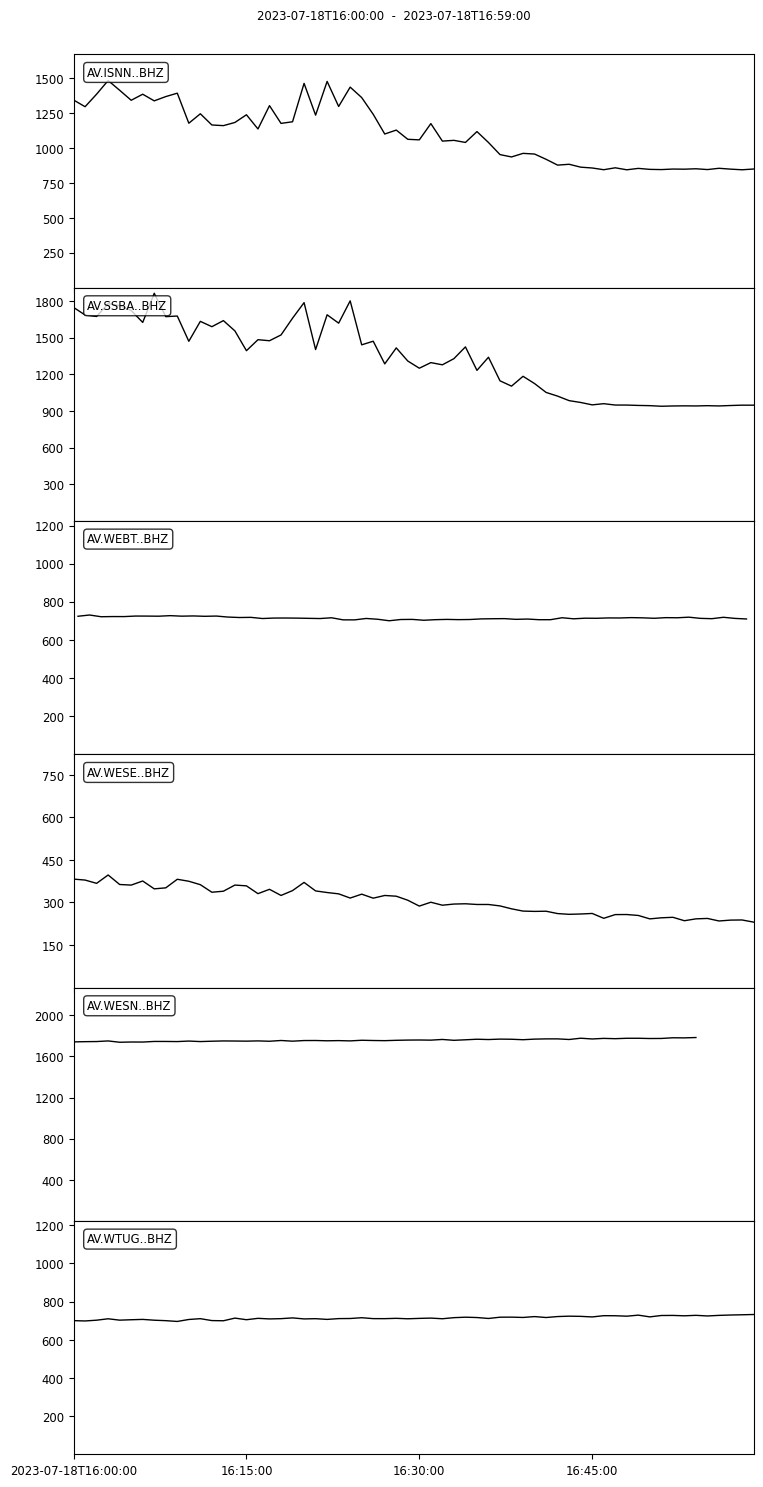

In [3]:
rsam1m = RSAM.RSAM(st=st, sampling_interval=60.0)
print(rsam1m.stream)
rsam1m.plot()
#rsam1m.write(rsamfile='rsam.mseed', format='mseed')
rsam1m.write(format='mseed')
rsam1m.write(format='pickle')
rsamobj = RSAM.read_RSAM('rsam.20230718.mean.60.pkl')
print(rsamobj.stream)

In [ ]:
# White Island Eruption
fdsnURL = "GEONET"
searchRadiusDeg = 0.5
olat=54.755833 # change this
olon=-163.9675 # change this
startt = obspy.core.UTCDateTime("2019-12-08T00:00:00.000")
hours_of_data = 26
endt = startt + hours_of_data * 60 * 60
network = 'NZ'
chanstring = 'HHZ'
stationXmlFile = 'White_Island_network.xml' 
mseedfile = stationXmlFile.replace('.xml','.mseed')
inv, st = FDSNdownload(stationXmlFile, mseedfile, fdsnURL, startt, endt, olat, olon, \
        searchRadiusDeg, network=network, chanstring=chanstring)
rsamWI = RSAM.RSAM(st=st, sampling_interval=60.0)
print(rsamWI.stream)

In [ ]:
stations = ["WIZ", "WSRZ"] # two stations on White Island
st = obspy.Stream() # this will hold our raw seismic data
for station in stations:   
    this_st = client_geonet.get_waveforms(network, station,"*", chanstring, startt, endt, attach_response=True)
    for tr in this_st:
        st = st.append(tr)
    
    # remove instrument response
    VEL = st.copy()
    VEL.detrend(type='linear') # remove a linear trend
    VEL.filter('bandpass', freqmin=0.1, freqmax=25.0, zerophase=True, corners=2) # filter from 0.1 - 25 Hz
    VEL.remove_response(output='VEL')
print(VEL)
VEL.plot();

# Redoubt volcano eruption, March 2009
Redoubt volcano in Alaska erupted (at least) 19 times from March-April, 2009. The first magmatic explosion was preceded by an earthquake swarm. Events got closer and closer together, merging into tremor. 

In [ ]:
fdsnURL = "IRIS"
searchRadiusDeg = 0.5
olat=54.755833 # change this
olon=-163.9675 # change this
startt = obspy.core.UTCDateTime("2009-03-22T00:00:00.000")
hours_of_data = 32
endt = startt + hours_of_data * 60 * 60
network = 'AV'
chanstring = 'EHZ'
stationXmlFile = 'Redoubt20090322.xml' 
mseedfile = stationXmlFile.replace('.xml','.mseed')
inv, st = FDSNdownload(stationXmlFile, mseedfile, fdsnURL, startt, endt, olat, olon, \
        searchRadiusDeg, network=network, chanstring=chanstring)
rsamRD = RSAM.RSAM(st=st, sampling_interval=60.0)
print(rsamRD.stream)